In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit as plogis
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## DGP

In [ ]:
def dgp_simulation(n_obs=20000, 
                   SEED=123,
                   beta_0=0.45,        # Intercept
                   beta_t=-0.85,       # Treatement Effect
                   beta_X=[-0.5, 0.1], # Effects of Covariates
                   beta_TX=[0.7],      # Interaction Effect
                   p0=0,               # Noise variables 
                   confounder=False
                   ):
    
    np.random.seed(SEED)

    p = len(beta_X) 
    mu = np.zeros(p + p0)
    rho = 0.1
    Sigma = np.full((p + p0, p + p0), rho)
    np.fill_diagonal(Sigma, 1)                                                   # Covariance Matrix

    data = multivariate_normal.rvs(mean=mu, cov=Sigma, size=n_obs)
    data_df = pd.DataFrame(data, columns=[f'X{i+1}' for i in range(p + p0)])

    beta_X_full = np.array(beta_X + [0] * p0)                                    # array with covarites  + noise vars
    beta_TX = np.array(beta_TX)

    if confounder is not False:
        Tr = np.random.binomial(1, plogis(0.5 * data_df.iloc[:, confounder]), size=n_obs)
    else:
        Tr = np.random.binomial(1, 0.5, size=n_obs)                             # Random Treatment RCT

    Tr = np.array(Tr)
    X_effect = data @ beta_X_full   #XtB
    interaction = (data[:, :len(beta_TX)] @ beta_TX) * Tr                     # treated pats get an additionl effect beta _TX

    logit_Y = beta_0 + beta_t * Tr + X_effect + interaction                    # dgp for generating Y

    Y_prob = plogis(logit_Y)
    Y = np.random.binomial(1, Y_prob)                                          # sampling Y 

    Y1 = plogis(beta_0 + beta_t + X_effect + data[:, 0] * beta_TX[0])
    Y0 = plogis(beta_0 + X_effect)
    ITE_true = Y1 - Y0

    simulated_df = pd.DataFrame({
        'ID': np.arange(1, n_obs + 1),
        'Y': Y,
        'Treatment': Tr,
        **data_df,
        'Y1': Y1,
        'Y0': Y0,
        'ITE_true': ITE_true,
        'Y_prob': Y_prob
    })

    return simulated_df

def split_train_val_test(df, val_size=0.25, test_size=0.25, seed=12345):
    df_train_val, df_test = train_test_split(df, test_size=test_size, random_state=seed)
    relative_val_size = val_size / (1 - test_size)
    df_train, df_val = train_test_split(df_train_val, test_size=relative_val_size, random_state=seed)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)


def plot_estimated_vs_true_ite_colored(df_result, title_suffix=''):
    if 'ITE_true' not in df_result.columns:
        print(f"No 'ITE_true' column found in dataset. Skipping plot {title_suffix}.")
        return

    plt.figure(figsize=(8, 6))

    # Scatter: untreated
    untreated = df_result[df_result['Treatment'] == 0]
    plt.scatter(untreated['ITE_true'], untreated['ITE_hat'], alpha=0.2, label='Untreated (T=0)', color='blue')

    # Scatter: treated
    treated = df_result[df_result['Treatment'] == 1]
    plt.scatter(treated['ITE_true'], treated['ITE_hat'], alpha=0.2, label='Treated (T=1)', color='orange')

    # Diagonal reference line
    min_val = min(df_result['ITE_true'].min(), df_result['ITE_hat'].min())
    max_val = max(df_result['ITE_true'].max(), df_result['ITE_hat'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: Estimated = True')

    plt.xlabel('True ITE')
    plt.ylabel('Estimated ITE')
    plt.title(f'Estimated vs. True ITE {title_suffix}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## data

In [49]:
df = dgp_simulation(n_obs=10000)
df_train, df_val, df_test = split_train_val_test(df)
df_train.head(5)

,ID,Y,Treatment,X1,X2,Y1,Y0,ITE_true,Y_prob
0,6795,0,1,-0.272673,0.669215,0.404292,0.657744,-0.253452,0.404292
1,592,0,0,0.928227,-1.593354,0.407650,0.456746,-0.049097,0.456746
2,8740,1,0,1.235311,1.163071,0.490843,0.487166,0.003678,0.487166
3,1686,0,0,-0.184983,0.620478,0.407346,0.646694,-0.239348,0.646694
4,8627,1,0,-0.015492,-0.577202,0.386792,0.598694,-0.211902,0.598694


In [50]:
# True ATEs from known potential outcomes
ate_train = df_train['ITE_true'].mean()
ate_test = df_test['ITE_true'].mean()

print(f"True ATE (train): {ate_train:.4f}")
print(f"True ATE (test):  {ate_test:.4f}")

True ATE (train): -0.2024
True ATE (test):  -0.2106


In [ ]:

def t_learner_logistic(df_train, df_test, feature_cols, outcome_col='Y', treatment_col='Treatment'):
    # Split the training set into treated and untreated
    treated = df_train[df_train[treatment_col] == 1]
    untreated = df_train[df_train[treatment_col] == 0]

    # Train models separately for treated and untreated groups
    model_treated = LogisticRegression(max_iter=1000)
    model_treated.fit(treated[feature_cols], treated[outcome_col])

    model_untreated = LogisticRegression(max_iter=1000)
    model_untreated.fit(untreated[feature_cols], untreated[outcome_col])

    # Predict on test set
    mu1_test = model_treated.predict_proba(df_test[feature_cols])[:, 1]
    mu0_test = model_untreated.predict_proba(df_test[feature_cols])[:, 1]
    ite_test = mu1_test - mu0_test

    df_result_test = df_test.copy()
    df_result_test['mu1_hat'] = mu1_test
    df_result_test['mu0_hat'] = mu0_test
    df_result_test['ITE_hat'] = ite_test

    # Predict on training set
    mu1_train = model_treated.predict_proba(df_train[feature_cols])[:, 1]
    mu0_train = model_untreated.predict_proba(df_train[feature_cols])[:, 1]
    ite_train = mu1_train - mu0_train

    df_result_train = df_train.copy()
    df_result_train['mu1_hat'] = mu1_train
    df_result_train['mu0_hat'] = mu0_train
    df_result_train['ITE_hat'] = ite_train

    return df_result_train, df_result_test, model_treated, model_untreated

## logistisc Regression

Test Mean absolute error: 0.015469935994933801
Train Mean absolute error: 0.015443474704382225


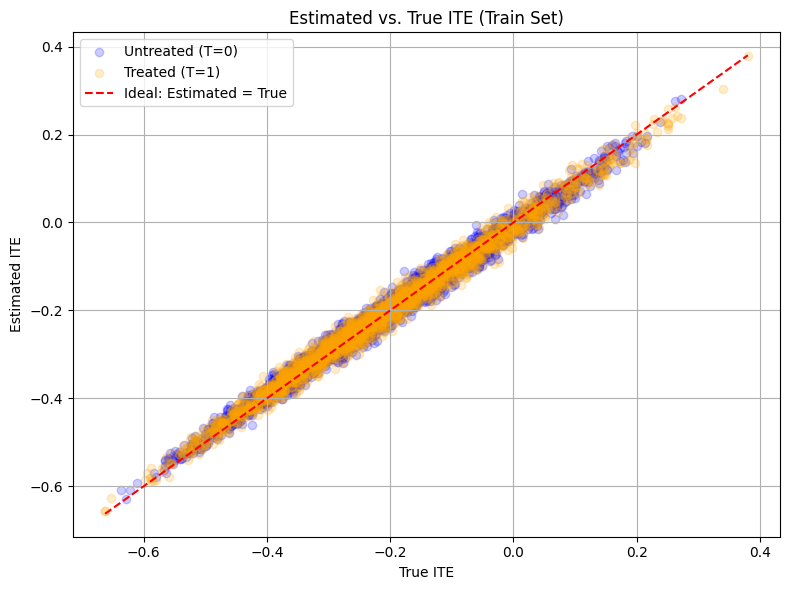

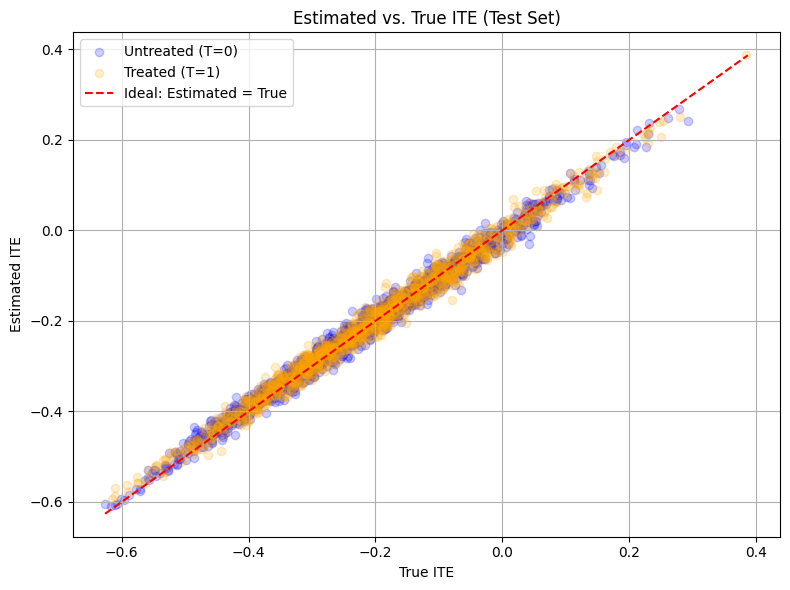

In [58]:
# t learner logsitc
df_result_train, df_result_test, model_t, model_u = t_learner_logistic(df_train, df_test, feature_cols=['X1', 'X2'])

# MAE train Vs test
if 'ITE_true' in df_result_test.columns:
    print("Test Mean absolute error:", np.mean(np.abs(df_result_test['ITE_hat'] - df_result_test['ITE_true'])))

if 'ITE_true' in df_result_train.columns:
    print("Train Mean absolute error:", np.mean(np.abs(df_result_train['ITE_hat'] - df_result_train['ITE_true'])))


plot_estimated_vs_true_ite_colored(df_result_train, title_suffix='(Train Set)')
plot_estimated_vs_true_ite_colored(df_result_test, title_suffix='(Test Set)')

## RF

In [61]:

def t_learner_random_forest(df_train, df_test, feature_cols, outcome_col='Y', treatment_col='Treatment'):
    # Split training data into treated and untreated
    treated = df_train[df_train[treatment_col] == 1]
    untreated = df_train[df_train[treatment_col] == 0]

    # Train separate random forest classifiers
    model_treated = RandomForestClassifier(n_estimators=1000, random_state=0)
    model_treated.fit(treated[feature_cols], treated[outcome_col])

    model_untreated = RandomForestClassifier(n_estimators=1000, random_state=0)
    model_untreated.fit(untreated[feature_cols], untreated[outcome_col])

    # Predict potential outcomes on test set
    mu1_test = model_treated.predict_proba(df_test[feature_cols])[:, 1]
    mu0_test = model_untreated.predict_proba(df_test[feature_cols])[:, 1]
    ite_test = mu1_test - mu0_test

    df_result_test = df_test.copy()
    df_result_test['mu1_hat'] = mu1_test
    df_result_test['mu0_hat'] = mu0_test
    df_result_test['ITE_hat'] = ite_test

    # Predict potential outcomes on train set
    mu1_train = model_treated.predict_proba(df_train[feature_cols])[:, 1]
    mu0_train = model_untreated.predict_proba(df_train[feature_cols])[:, 1]
    ite_train = mu1_train - mu0_train

    df_result_train = df_train.copy()
    df_result_train['mu1_hat'] = mu1_train
    df_result_train['mu0_hat'] = mu0_train
    df_result_train['ITE_hat'] = ite_train

    return df_result_train, df_result_test, model_treated, model_untreated


Test MAE: 0.23045418757101843
Train MAE: 0.31628206727773367


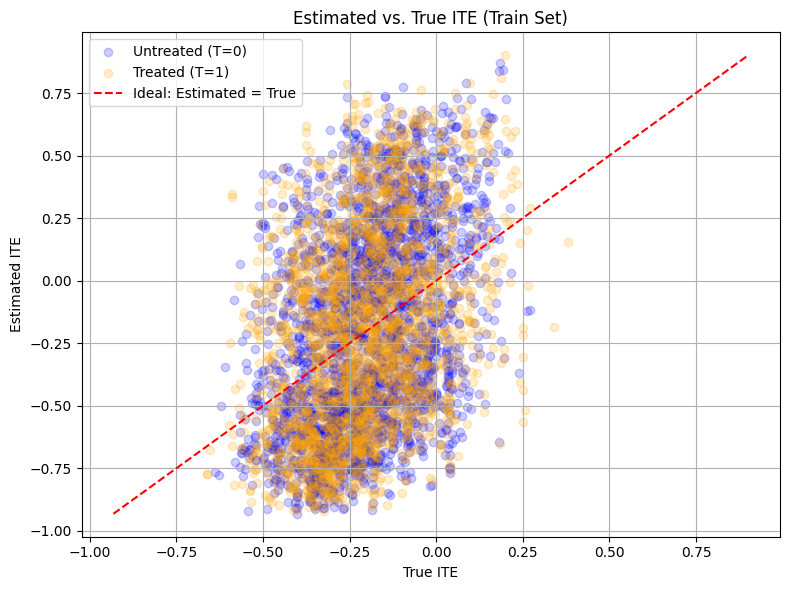

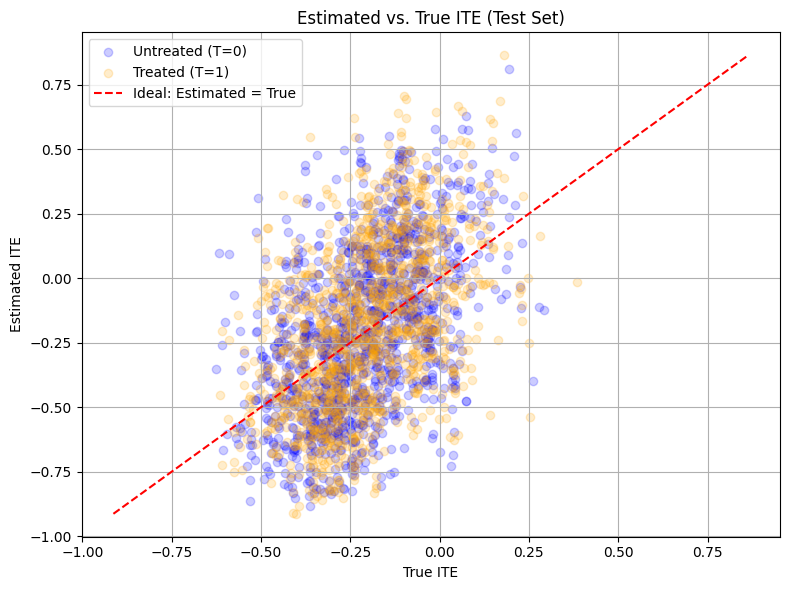

In [62]:
feature_cols = ['X1', 'X2']
df_result_train, df_result_test, model_t, model_u = t_learner_random_forest(df_train, df_test, feature_cols)

if 'ITE_true' in df_result_test.columns:
    print("Test MAE:", np.mean(np.abs(df_result_test['ITE_hat'] - df_result_test['ITE_true'])))
if 'ITE_true' in df_result_train.columns:
    print("Train MAE:", np.mean(np.abs(df_result_train['ITE_hat'] - df_result_train['ITE_true'])))

plot_estimated_vs_true_ite_colored(df_result_train, title_suffix="(Train Set)")
plot_estimated_vs_true_ite_colored(df_result_test, title_suffix="(Test Set)")